## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
plt.style.use('dark_background')

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# Defining constants given in the exercise description.
mu = 0
std = 0.03
stim_strengths = lambda batch_size: [3.2 / 100 * random.choice(np.array([1, 2, 4, 8, 16])) for i in range(batch_size)]

In [3]:
def get_input(u_bar, t_step, mu, std):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 45:
            u[t] = u_bar + np.random.normal(mu, std)
        else:
            u[t] = np.random.normal(mu, std)
    
    return u

def generate_data(stim_strengths, t_step, mu, std):
    U = np.zeros((len(stim_strengths), t_step))
    y = np.zeros(len(stim_strengths))
    for trial, stim_strength in enumerate(range(len(stim_strengths))):
        u_bar = np.random.uniform(-stim_strengths[trial], stim_strengths[trial])
        U[trial] = get_input(u_bar, t_step, mu, std)
        y[trial] = np.sign(u_bar)
        
    return U, y

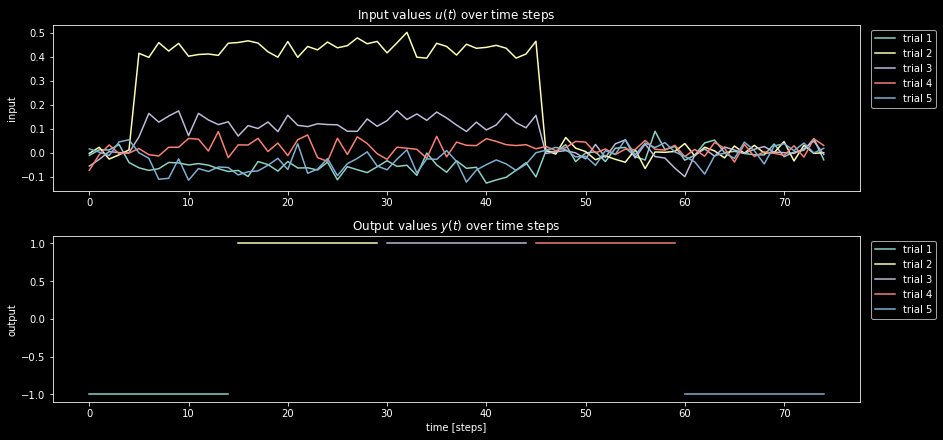

In [4]:
t_steps = 75
U, y = generate_data(stim_strengths(5), t_steps, mu, std)

fig, axs = plt.subplots(2, 1, figsize = (13, 6), constrained_layout = True)
for trial in range(U.shape[0]):
    axs[0].set_title(r'Input values $u(t)$ over time steps')
    axs[0].plot(np.arange(0, t_steps, 1), U[trial], label = f'trial {trial+1}')
    axs[0].set_ylabel('input')
    
    axs[1].set_title(r'Output values $y(t)$ over time steps')
    axs[1].plot(np.arange(trial * t_steps/U.shape[0], (trial+1) * t_steps/U.shape[0], 1), 
                np.full(int(t_steps/U.shape[0]), y[trial]), label = f'trial {trial+1}')
    axs[1].set_ylabel('output')
    axs[1].set_xlabel('time [steps]')

for i in range(2):
    axs[i].legend(loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

In [5]:
# Define the input-to-hidden, hidden-to-hidden and hidden-to-output matrices.
I = lambda N: np.random.normal(0, 1, N)
J = lambda N: 1 / N * (np.random.normal(0, 1, N).reshape(N, 1)@np.random.normal(0, 1, N).reshape(N, 1).T)
w = lambda N: np.random.normal(0, 1, N)

# Define the functions.
phi = lambda x: np.tanh(x)
dynamics = lambda u, x, t, I, J, tau=100: (-x + J@phi(x) + I*u[t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [6]:
def forward_euler(u, x, t, I, J, dt=20, tau=100):
    x = x + dt * dynamics(u, x, t, I, J, tau)
    return x

In [7]:
class RNNLayer(nn.Module):
    '''
    Single custom RNN layer with a low-rank connectivity matrix and a leak term.
    '''
    def __init__(self, input_size, hidden_size, I, J):
        super(RNNLayer, self).__init__()
        
        # Define the architecture of the RNN layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        i2h_weight = torch.Tensor(hidden_size, input_size)
        h2h_weight = torch.Tensor(hidden_size, hidden_size)
        self.i2h_weight = nn.Parameter(i2h_weight)
        self.h2h_weight = nn.Parameter(h2h_weight)
        
        i2h_bias = torch.Tensor(hidden_size)
        h2h_bias = torch.Tensor(hidden_size)
        self.i2h_bias = nn.Parameter(i2h_bias)
        self.h2h_bias = nn.Parameter(h2h_bias)
        
        # Initialize weights and biases.
        self.i2h_weight = nn.Parameter(torch.from_numpy(I))
        self.h2h_weight = nn.Parameter(torch.from_numpy(J))
        
        self.i2h_bias = self.h2h_bias = nn.Parameter(torch.from_numpy(np.zeros(hidden_size)))
        
    def forward(self, u, t, x):
        x = forward_euler(u, x, t, self.i2h_weight.detach().numpy(), self.h2h_weight.detach().numpy())
        return x

In [8]:
U, y = generate_data(stim_strengths(5), 75, mu, std)
U.shape

(5, 75)

In [9]:
N = 5
x = np.random.normal(0, 1, N)
rnn_layer = RNNLayer(1, N, I(N), J(N))
rnn_layer(U[0], 0, x)

array([ 0.14243987,  1.46347898, -0.09834568, -0.43690398, -0.46996853])

In [10]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, I, J, w):
        super(Model, self).__init__()
        
        # Define the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Define the network layers.
        self.rnn = RNNLayer(input_size, hidden_size, I, J)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Initialization of weights and biases of the linear layer.
        self.fc.weight.data = torch.from_numpy(w.reshape(output_size, hidden_size)).float()
        self.fc.bias.data = torch.from_numpy(np.zeros(output_size)).float()
        
    def forward(self, u, t, x):
        x = self.rnn(u, t, x)
        out = 1 / self.hidden_size * self.fc(torch.from_numpy(phi(x)))
        
        return x, out

__3. Train a network of size $N = 128$ by minimizing the mean squared error using stochastic gradient descent.__

In [11]:
def train_network(model, inputs, targets, hidden):
    pass

In [12]:
N = 128
t_steps = 15
batch_size = 32

stim_strengths_rnn = stim_strengths(batch_size)
U, y = generate_data(stim_strengths_rnn, t_steps, mu, std)

In [13]:
# Instantiate the model with hyperparameters.
input_size = 1
hidden_size = N
output_size = 1
model = Model(input_size, N, output_size, I(N), J(N), w(N))
model

Model(
  (rnn): RNNLayer()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

rnn.i2h_weight tensor([-0.4612, -0.1110,  0.2939, -0.9919,  0.1399, -1.3041,  0.9435, -0.0096,
         0.1046, -0.0787,  0.5921,  1.2466,  0.2540, -0.1642,  1.2281,  0.1535,
         1.3615,  0.2920, -1.7626,  0.6654, -0.7559, -0.1974,  0.0767,  0.5448,
        -1.8845,  1.0043,  0.2227,  0.4283, -1.6944, -2.2713, -0.1744,  0.7401,
        -1.2016,  0.9751,  0.7651, -0.2762,  2.5422,  0.2539, -1.0247, -0.3096,
        -0.6513,  0.3994, -0.5963, -0.2334, -2.1025, -1.0788, -1.2507,  0.0929,
         0.8259,  0.9801,  1.5553, -0.3200,  0.6499, -0.2056, -0.7810,  1.2826,
        -1.1376, -0.2138, -0.5621, -0.2596, -0.3448, -0.6470, -0.0590, -0.1686,
        -0.6524, -1.9705,  0.6158,  0.5494, -1.4964,  0.3965, -0.2166,  0.6094,
        -1.9389,  0.9798,  0.8762,  0.9287,  0.7156, -0.9931,  1.2945, -0.8085,
         0.4155, -0.5595,  1.2681,  0.4405, -0.6239,  0.9452, -1.9185, -0.6521,
        -2.3768,  0.1324,  0.1892, -0.7955,  0.5588,  0.1119, -0.4931, -0.3249,
        -0.4453, -0.8136,

In [15]:
# Define hyperparemeters for training.
n_epochs = 100

In [16]:
# train_network(model, U, y, X)

In [17]:
# model(U, X)